In [55]:
import os
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy
from scipy.signal import convolve
from tqdm import tqdm
import pickle 

Im_on_server = False

In [2]:
print('change')

change


In [3]:
def weight_dep(td,ti,u,W,ra):
    '''
    ra: desired rate
    td: tau_dep/tau_rec
    ti: tau_inact
    u: U_SE
    W: static_weight for the desired firing rate
    '''
    A=np.exp(-1/(ra*ti))
    B=np.exp(-1/(ra*td))
    D=A*B*(2*u-1)+(A+B)*(1-u)-1
    x=(A+A*B+B-1)/D
    return W/(x*u)

def weight_fac(tf,td,ti,U0,W,ra):
    '''
    ra: desired rate
    td: tau_dep/tau_rec
    tf: tau_fac
    ti: tau_inact
    U0: U_SE
    W: static_weight for the desired firing rate
    '''
    A=np.exp(-1/(ra*ti))
    B=np.exp(-1/(ra*td))
    C=np.exp(-1/(ra*tf))
    u=U0*C/(1+(U0-1)*C)
    D=A*B*(2*u-1)+(A+B)*(1-u)-1
    x=(A+A*B+B-1)/D
    return W/(x*u)

In [4]:
#load connectivity-matrices from Archishman
with open("Archishman/Connectivity_Matrices/Oct_13_all_weights_mat_specific_V2_1000.pkl", 'rb') as file:
    M = pickle.load(file)
#plt.imshow(M[5].astype(int), cmap='Blues', interpolation='none')
def get_nonzero_con(con_matrix):
    i_pre, j_post = np.nonzero(con_matrix)
    con_inds = np.vstack((i_pre, j_post))
    return con_inds


In [5]:
def get_neuron(tau_mem, Num,theta,V_r,tau_rp,R_in):
    """
    tau_mem -- membrane time constant
    Num -- number of neurons
    theta -- threshold of spike
    V_r -- reset potential
    tau_rp -- refractory period
    R_in -- membrane resistance
    """
    neuron = NeuronGroup(Num,
                         """
                         tau_mem : second
                         I_syn_ee : ampere
                         I_syn_ei : ampere
                         I_syn_ie : ampere
                         I_syn_ii : ampere
                         R : ohm
                         I_syn = I_syn_ee + I_syn_ei + I_syn_ie + I_syn_ii : ampere
                         dv/dt = -v/(tau_mem) + R*I_syn/tau_mem : volt (unless refractory) ###equation of the neuron (LIF, change here)
                         """,
                         threshold="v > theta",
                            reset="v = V_r",
                        refractory=tau_rp,
                         method="exact")

    neuron.tau_mem = tau_mem
    neuron.R = R_in
    return neuron

def get_synapses_stp(name, origin_neuron,target_neurons, epsilon ,tau_inact, Del ,A_SE, U_SE, tau_rec, tau_facil=None, con_inds=None):
    """
    name -- either ee, ei, ie, or ii
    origin_neuron, target_neurons -- origin and target populations
    epsilon -- connection probability
    A_SE -- absolute synaptic strength
    U_SE -- utilization of synaptic efficacy
    tau_inact -- inactivation time constant
    Del -- synaptic delay
    tau_rec -- recovery time constant
    tau_facil -- facilitation time constant (optional)
    """

    synapses_eqs = """
    dx/dt =  z/tau_rec   : 1 (clock-driven) # recovered
    dy/dt = -y/tau_inact : 1 (clock-driven) # active
    z = 1- x- y : 1 #inactive 
    A_SE : ampere
    U_SE : 1
    tau_inact : second
    tau_rec : second
    I_syn_{}_post = A_SE*y : ampere (summed)
    """.format(name)

    if tau_facil:
        synapses_eqs += """
        du/dt = -u/tau_facil : 1 (clock-driven)
        syn_w = u*x : 1 #effective synaptic weight in case of facilitatory synapses
        tau_facil : second
        """

        synapses_action = """
        u += U_SE*(1-u)
        y += u*x # important: update y first
        x += -u*x
        """
    else:
        synapses_action = """
        y += U_SE*x # important: update y first
        x += -U_SE*x
        """

    synapses = Synapses(origin_neuron,target=target_neurons,
                        model=synapses_eqs,
                        on_pre=synapses_action, delay=Del,
                        method="exponential_euler")
    
    if type(con_inds)!=type(None):
        pre_inds, post_inds = con_inds[0], con_inds[1]
        synapses.connect(i = pre_inds, j = post_inds)
    else:
        synapses.connect(p=epsilon)
    '''
    if you have a connectivity matrix, synapses.connect(i=inds[0],j=inds[1]), where inds[0] are the pre-indices, inds[1] are the post
    '''


    # start fully recovered
    synapses.x = 1.0
    synapses.y = 0.0

    synapses.tau_inact = tau_inact
    synapses.A_SE = A_SE #A_SE would not be the same if there is a connectivity matrix
    synapses.U_SE = U_SE 
    synapses.tau_rec = tau_rec

    if tau_facil:
        synapses.tau_facil = tau_facil

    return synapses

def get_synapses_static(name, origin_neuron, target_neurons, epsilon, tau_inact, Del ,A_SE, con_inds=None):
    """
    name -- either ee, ei, ie, or ii
    origin_neuron, target_neurons -- origin and target populations
    epsilon -- connection probability
    Del -- synaptic delay
    tau_inact -- inactivation time constant
    A_SE -- absolute synaptic strength
    U_SE -- utilization of synaptic efficacy
    """

    synapses_eqs = """
    dy/dt = -y/tau_inact : 1 (clock-driven) # active
    A_SE : ampere
    tau_inact : second
    I_syn_{}_post = A_SE*y : ampere (summed)
    """.format(name)
    synapses_action = """
    y += 1 # important
    """

    synapses = Synapses(origin_neuron,target=target_neurons,
                        model=synapses_eqs,
                        on_pre=synapses_action, delay=Del,
                        method="exponential_euler")
    
    if type(con_inds)!=type(None):
        pre_inds, post_inds = con_inds[0], con_inds[1]
        synapses.connect(i = pre_inds, j = post_inds)
    else:
        synapses.connect(p=epsilon)

    # starting condition
    synapses.y = 0.0

    synapses.tau_inact = tau_inact
    synapses.A_SE = A_SE
    
    return synapses

In [6]:
#bin and convolve data
def bin_tp_data(tp_data, T, dt):
    all_tps = tp_data[0]
    neuron_ind = tp_data[1]
    N = np.unique(neuron_ind).size
    nbins = int(T/dt)

    time_bins = np.arange(0,T+dt, dt) #T+dt includes right most edge of last bin -> T is last value -> no spike is missed as T is end of simulation
    binned_data = np.zeros([N, nbins])
    for ni in range(N):
        indices = tp_data[1]
        tps = all_tps[indices == ni] #for each neuron_id, take only time points that belong to it

        binned_data[ni], _ = np.histogram(tps, bins = time_bins)

    return time_bins, binned_data

#I use gaussian as filter, as it doesn't involve any abrupt changes (like exp) 
# Its symmetric but that's good for EPR:
# - loss of causality is not interesting for us, for example, we don't compare it with stimulus onset times
# - causal filters would be asymmetric in time, which would introduce an artificial irreversibility, even when the actual activity is reversibel

def gauss(x, mean=0,width=5,max=1): #TODO: choose width wisely
    return max * np.exp(-0.5*((x-mean)/width)**2)

from scipy.ndimage import gaussian_filter1d
def inst_rate(data, filter_width = 5, dt=1): #TODO: add kernel params
    sigma_bins = filter_width / dt  # std in bins
    inst_rate = gaussian_filter1d(data.astype(float), sigma=sigma_bins, axis=1, mode='constant')
    inst_rate *= np.sqrt(2 * np.pi) * sigma_bins
    return inst_rate

#define causal, exponential filter
def expfilt(x, tau, height=1, dt=1):
    '''for plotting of filter'''
    ntp = x.size
    half_ntp = ntp//2
    kernel = np.exp(-x / (tau/dt)) * height
    kernel[:half_ntp] = np.zeros([half_ntp])   
    return kernel

def inst_rate_exp(data, tau=10, height=1, dt=1, axis=-1):
    """
    Symmetric exponential smoothing along a given axis.
    tau: decay parameter (higher = wider smoothing).
    """
    # Kernel length: ~6*tau to capture most mass
    ndim, ntp = data.shape
    half_ntp = ntp//2
    x = np.linspace(-half_ntp, half_ntp, ntp)
    kernel = np.exp(-x / (tau/dt)) * height
    kernel[:half_ntp] = np.zeros([half_ntp])
    #kernel /= kernel.sum()

    return convolve(data, kernel[np.newaxis], mode="same", method='auto') #[np.newaxis]




In [7]:
### theta=15
def sim_static(savelabel,num,eps,g, f_ext, sim_time, con_inds=None):
    """
    savelabel -- label with which the items would be saved
    num -- number of neurons
    eps -- connection probability
    g -- relative inhibitory to excitatory synaptic strength
    f_ext -- ratio of external stimulus rate to threshold rate
    sim_time -- simulation time
    """

    # network parameters
    N_E = num
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = eps
    C_E = epsilon * N_E
    C_ext = C_E
    
    
    ##name of synapses
    ee = "ee"
    ei = "ei"
    ie = "ie"
    ii = "ii"

    # neuron parameters
    tau = 20 * ms
    theta = 15 * mV
    V_r = 0 * mV 
    tau_rp = 2 * ms
    R_in= 80 * Mohm

    # synapse parameters
    J_syn_stat= 10 * pA
    D = 1.0 * ms
    tau_in = 1.5*ms ## synaptic time constant
    defaultclock.dt = 0.1 * ms

    ### defining neurons
    neurons = get_neuron(tau, N, theta,V_r,tau_rp, R_in)
   
    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    # external stimulus
    J_ext=0.1*mV
    threshold_rate=theta/(J_ext*C_E*tau) ### rate required to start spiking
    rate = f_ext*threshold_rate ## since f_ext is the ratio between desired rate and threshold rate
    P_inp = PoissonInput(neurons, 'v', C_E, rate, weight=J_ext)
    
    #defining synapses
    ee_synapses=get_synapses_static(ee, excitatory_neurons, excitatory_neurons, epsilon, tau_in, D, J_syn_stat, con_inds=con_inds)
    ei_synapses=get_synapses_static(ei, excitatory_neurons, inhibitory_neurons, epsilon, tau_in, D, J_syn_stat)
    
    ie_synapses=get_synapses_static(ie, inhibitory_neurons, excitatory_neurons, epsilon, tau_in, D, -g*J_syn_stat)
    ii_synapses=get_synapses_static(ii, inhibitory_neurons, inhibitory_neurons, epsilon, tau_in, D, -g*J_syn_stat)

    ##monitoring spikes
    spike_monitor_exc = SpikeMonitor(excitatory_neurons)
    spike_monitor_inh = SpikeMonitor(inhibitory_neurons)
    
    
    net=Network(neurons, spike_monitor_exc,spike_monitor_inh)
    
    net.add(ee_synapses,ei_synapses,ie_synapses,ii_synapses)
    
    net.add(P_inp)
    
    net.run(sim_time, report='text')
    #M: save spike-times in npy format
    np.save('spikes_{}_EXC.npy'.format(savelabel), np.array([spike_monitor_exc.t/ms, spike_monitor_exc.i]))
    np.save('spikes_{}_INH.npy'.format(savelabel), np.array([spike_monitor_inh.t/ms, spike_monitor_inh.i]))
    # with open('spikes_{}_EXC.csv'.format(savelabel),'w') as f:
    #     writer=csv.writer(f)
    #     for it in range(len(spike_monitor_exc.t/ms)):
    #         writer.writerow([ spike_monitor_exc.t[it]/ms, spike_monitor_exc.i[it]])
    
    # with open('spikes_{}_INH.csv'.format(savelabel),'w') as f:
    #     writer=csv.writer(f)
    #     for it in range(len(spike_monitor_inh.t/ms)):
    #         writer.writerow([ spike_monitor_inh.t[it]/ms, spike_monitor_inh.i[it]])

    return spike_monitor_exc, spike_monitor_inh

In [46]:
#by M: simulate feed-forward network
def sim_static_ff(savelabel,num,eps,g, f_ext, sim_time, con_inds=None):
    """
    savelabel -- label with which the items would be saved
    num -- number of neurons
    eps -- connection probability
    g -- relative inhibitory to excitatory synaptic strength
    f_ext -- ratio of external stimulus rate to threshold rate
    sim_time -- simulation time
    """

    # network parameters
    gamma = 0.25
    N = num
    epsilon = eps
    C_E = epsilon * num
    C_ext = C_E
    
    
    ##name of synapses
    ee = "ee"
    ei = "ei"
    ie = "ie"
    ii = "ii"


    # neuron parameters
    tau = 20 * ms
    theta = 15 * mV
    V_r = 0 * mV 
    tau_rp = 2 * ms
    R_in= 80 * Mohm

    # synapse parameters
    J_syn_stat= 5000 * pA
    D = 10.0 * ms
    tau_in = 1.5*ms ## synaptic time constant
    defaultclock.dt = 0.1 * ms

    ### defining neurons
    neurons = get_neuron(tau, N, theta,V_r,tau_rp, R_in)

    ### divide neurons into layers

    layer1 = neurons[:5]
    layer2 = neurons[5:10]
    layer3 = neurons[10:15]
    
    # excitatory_neurons = neurons[:N_E]
    # inhibitory_neurons = neurons[N_E:]

    # external stimulus
    J_ext=0.1*mV
    threshold_rate=theta/(J_ext*C_E*tau) ### rate required to start spiking
    rate = f_ext*threshold_rate ## since f_ext is the ratio between desired rate and threshold rate
    P_inp = PoissonInput(layer1, 'v', C_E, rate, weight=J_ext)
    
    #defining synapses
    # ee_synapses=get_synapses_static(ee, excitatory_neurons, excitatory_neurons, epsilon, tau_in, D, J_syn_stat, con_inds=con_inds)
    # ei_synapses=get_synapses_static(ei, excitatory_neurons, inhibitory_neurons, epsilon, tau_in, D, J_syn_stat)
    
    # ie_synapses=get_synapses_static(ie, inhibitory_neurons, excitatory_neurons, epsilon, tau_in, D, -g*J_syn_stat)
    # ii_synapses=get_synapses_static(ii, inhibitory_neurons, inhibitory_neurons, epsilon, tau_in, D, -g*J_syn_stat)

    ### define synapses across layers
    l1l2_synapses=get_synapses_static(ee, layer1, layer2, epsilon, tau_in, D, J_syn_stat, con_inds=con_inds)
    l2l3_synapses=get_synapses_static(ee, layer2, layer3, epsilon, tau_in, D, J_syn_stat)

    ##monitoring spikes
    spike_monitor_l1 = SpikeMonitor(layer1)
    spike_monitor_l2 = SpikeMonitor(layer2)
    spike_monitor_l3 = SpikeMonitor(layer3)

    
    net=Network(neurons, spike_monitor_l1,spike_monitor_l2, spike_monitor_l3)
    
    net.add(l1l2_synapses,l2l3_synapses)
    
    net.add(P_inp)
    
    net.run(sim_time, report='text')
    #M: save spike-times in npy format
    np.save('spikes_{}_l1.npy'.format(savelabel), np.array([spike_monitor_l1.t/ms, spike_monitor_l1.i]))
    np.save('spikes_{}_l2.npy'.format(savelabel), np.array([spike_monitor_l2.t/ms, spike_monitor_l2.i]))
    np.save('spikes_{}_l3.npy'.format(savelabel), np.array([spike_monitor_l3.t/ms, spike_monitor_l3.i]))

    # with open('spikes_{}_EXC.csv'.format(savelabel),'w') as f:
    #     writer=csv.writer(f)
    #     for it in range(len(spike_monitor_exc.t/ms)):
    #         writer.writerow([ spike_monitor_exc.t[it]/ms, spike_monitor_exc.i[it]])
    
    # with open('spikes_{}_INH.csv'.format(savelabel),'w') as f:
    #     writer=csv.writer(f)
    #     for it in range(len(spike_monitor_inh.t/ms)):
    #         writer.writerow([ spike_monitor_inh.t[it]/ms, spike_monitor_inh.i[it]])

    return spike_monitor_l1, spike_monitor_l2, spike_monitor_l3

In [9]:
### different starting time
def sim_stp(savelabel, num, eps,g, f_ext, sim_time, tau_rec1, tau_rec2, tau_facil1=None,  tau_facil2=None):
    """
    savelabel -- label with which the items would be saved
    num -- number of neurons
    eps -- connection probability
    g -- relative inhibitory to excitatory synaptic strength
    f_ext -- ratio of external stimulus rate to threshold rate
    sim_time -- simulation time
    """

    # network parameters
    N_E = num
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = eps
    C_E = epsilon * N_E*10
    C_ext = C_E
    
    ##name of synapses
    ee = "ee"
    ei = "ei"
    ie = "ie"
    ii = "ii"

    # neuron parameters
    tau = 20 * ms
    theta = 15 * mV
    V_r = 0 * mV #check reset
    tau_rp = 2 * ms
    R_in= 80 * Mohm

    
    J_ext = 0.1 * mV
    
    
    ###time constants and synapse parameters
    tau_inact_all= 1.5*ms ## synaptic time constant
    tau_rec_fac= tau_rec1
    tau_rec_dep= tau_rec2
    U_fac=0.03
    U_dep=0.6
    J_syn_stat = 10*pA
    J_syn_dep = J_syn_stat/U_dep 
    J_syn_fac = J_syn_stat/U_fac
    '''
    J_syn_dep and J_syn_stat are chosen such that the first PSP is the same. 
    If you want a desired firing rate, and know the "static_weight" (in pA) that can lead to it, use the functions weight_dep and weight_fac
    If you know the desired weight in mV/nS instead of pA, use the neuron parameters to convert from to pA
    '''
    D = 1.0 * ms 


    defaultclock.dt = 0.1 * ms
    
    neurons = get_neuron(tau, N, theta,V_r,tau_rp, R_in)
   
    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    #external input
    threshold_rate=theta/(J_ext*C_E*tau)
    rate = f_ext*threshold_rate
    P_inp = PoissonInput(neurons, 'v', C_E, rate, weight=J_ext)
    
    
    if tau_facil1:
        tau_inact1 = tau_inact_all
        A_SE1 = J_syn_fac
        tau_rec1 = tau_rec_fac
        U_SE1 = U_fac
        ee_synapses = get_synapses_stp(ee, excitatory_neurons,excitatory_neurons, epsilon ,tau_inact1, D, A_SE1, U_SE1, tau_rec1, tau_facil1)
        ei_synapses = get_synapses_stp(ei, excitatory_neurons,inhibitory_neurons, epsilon ,tau_inact1, D, A_SE1, U_SE1, tau_rec1, tau_facil1)
    else:
        tau_inact2 = tau_inact_all
        A_SE2 = J_syn_dep
        tau_rec2 = tau_rec_dep
        U_SE2 = U_dep
        ee_synapses = get_synapses_stp(ee, excitatory_neurons,excitatory_neurons, epsilon ,tau_inact2, D, A_SE2, U_SE2, tau_rec2, tau_facil1)
        ei_synapses = get_synapses_stp(ei, excitatory_neurons,inhibitory_neurons, epsilon ,tau_inact2, D, A_SE2, U_SE2, tau_rec2, tau_facil1)
    
    if tau_facil2:
        tau_inact3 = tau_inact_all
        A_SE3 = -g*J_syn_fac
        tau_rec3 = tau_rec_fac
        U_SE3 = U_fac
        ie_synapses = get_synapses_stp(ie, inhibitory_neurons,excitatory_neurons, epsilon ,tau_inact3, D, A_SE3, U_SE3, tau_rec3, tau_facil2)
        ii_synapses = get_synapses_stp(ii, inhibitory_neurons,inhibitory_neurons, epsilon ,tau_inact3, D, A_SE3, U_SE3, tau_rec3, tau_facil2)
    else:
        tau_inact4 = tau_inact_all
        A_SE4 = - g * J_syn_dep
        tau_rec4 = tau_rec_dep
        U_SE4 = U_dep
        ie_synapses = get_synapses_stp(ie, inhibitory_neurons,excitatory_neurons, epsilon ,tau_inact4, D, A_SE4, U_SE4, tau_rec4, tau_facil2)
        ii_synapses = get_synapses_stp(ii, inhibitory_neurons,inhibitory_neurons, epsilon ,tau_inact4, D, A_SE4, U_SE4, tau_rec4, tau_facil2)
    
    spike_monitor_exc = SpikeMonitor(excitatory_neurons,variables='I_syn')
    spike_monitor_inh = SpikeMonitor(inhibitory_neurons,variables='I_syn')
    
    net=Network(neurons, spike_monitor_exc, spike_monitor_inh)
    
    net.add(ee_synapses,ei_synapses,ie_synapses,ii_synapses)
    
    net.add(P_inp)
    
    net.run(sim_time, report='text')
    
    #M: save spike-times in npy format
    np.save('spikes_{}_EXC.npy'.format(savelabel), np.array([spike_monitor_exc.t/ms, spike_monitor_exc.i]))
    np.save('spikes_{}_INH.npy'.format(savelabel), np.array([spike_monitor_inh.t/ms, spike_monitor_inh.i]))    
    # with open('spikes_{}_EXC.csv'.format(savelabel),'w') as f:
    #     writer=csv.writer(f)
    #     for it in range(len(spike_monitor_exc.t/ms)):
    #         writer.writerow([ spike_monitor_exc.t[it]/ms, spike_monitor_exc.i[it], spike_monitor_exc.I_syn[it]/pA ])
    
    # with open('spikes_{}_INH.csv'.format(savelabel),'w') as f:
    #     writer=csv.writer(f)
    #     for it in range(len(spike_monitor_inh.t/ms)):
    #         writer.writerow([ spike_monitor_inh.t[it]/ms, spike_monitor_inh.i[it], spike_monitor_inh.I_syn[it]/pA])
            
    return spike_monitor_exc, spike_monitor_inh

In [13]:
#M: run simulation
np.random.seed(42)

Num=12 #num of exc neurons (+1/4 of inh neurons)
Num_tot = Num + round(0.25*Num) #num of exc + inh neurons
eps= 0.8#0.1 #eps -- connection probability
g= 5 #5 #g -- relative inhibitory to excitatory synaptic strength
ext=1 #1 #f_ext -- ratio of external stimulus rate to threshold rate
T=10000

Mcon_inds = None#get_nonzero_con(M[9,:Num,:Num])

parameters_static = {"static1000": {"num": Num,"gm": g,"eps": eps,"f_ext": ext,"time": T, 'con_inds':Mcon_inds}}

parameters_fac = {"Fac1000": {"num": Num,"gm": g,"eps": 0.1,"f_ext": ext,"time": T,
        "tau_rec1": 30*ms,
        "tau_rec2": 30*ms,
        "tau_facil1": 500*ms,
        "tau_facil2": 500*ms,}}

parameters_dep = {"Dep1000": {"num": Num,"gm": g,"eps": 0.1,"f_ext": ext,"time": T,
        "tau_rec1": 100*ms,
        "tau_rec2": 100*ms,
        "tau_facil1": None,
        "tau_facil2": None,}}


# for panel, params in parameters_fac.items():
#     sim_stp(panel,
#         params["num"],
#         params["eps"],
#         params["gm"],
#         params["f_ext"],
#         params["time"] * ms,
#         params["tau_rec1"],
#         params["tau_rec2"],
#         params["tau_facil1"],
#         params["tau_facil2"]
#     )

# for panel, params in parameters_dep.items():
#     sim_stp(panel,
#         params["num"],
#         params["eps"],
#         params["gm"],
#         params["f_ext"],
#         params["time"] * ms,
#         params["tau_rec1"],
#         params["tau_rec2"],
#         params["tau_facil1"],
#         params["tau_facil2"]
#     )

#actually simulate static-synapse network
for panel, params in parameters_static.items():
    SMe, SMi = sim_static(panel,
        params["num"],
        params["eps"],
        params["gm"],
        params["f_ext"],
        params["time"] * ms,
        params["con_inds"]
    )

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Starting simulation at t=0. s for a duration of 10. s
1.4681 s (14%) simulated in 10s, estimated 58s remaining.
2.8632 s (28%) simulated in 20s, estimated 50s remaining.
4.2145 s (42%) simulated in 30s, estimated 41s remaining.
5.7251 s (57%) simulated in 40s, estimated 30s remaining.
7.1034 s (71%) simulated in 50s, estimated 20s remaining.
8.5506 s (85%) simulated in 1m 0s, estimated 10s remaining.
9.966 s (99%) simulated in 1m 10s, estimated < 1s remaining.
10. s (100%) simulated in 1m 10s


In [14]:
#in case motifs also are for inhibitory cells, further develop this
'''Mcon_inds
#get array index up to which pre-cons of first 5 neurons are defined
Ne = 5

pre_indE = np.where(Mcon_inds[0]==Ne)[0][-1] #get last array index, where
pre5_postAll = Mcon_inds[:,:pre_ind5]
#from these, get index pairs, for which cons are between the first 5 neurons
post_ind5 = np.where(pre5_postAll[1]<=5)[0]
pre5_post5 = pre5_postAll[:,post_ind5]
pre5_post5'''


'Mcon_inds\n#get array index up to which pre-cons of first 5 neurons are defined\nNe = 5\n\npre_indE = np.where(Mcon_inds[0]==Ne)[0][-1] #get last array index, where\npre5_postAll = Mcon_inds[:,:pre_ind5]\n#from these, get index pairs, for which cons are between the first 5 neurons\npost_ind5 = np.where(pre5_postAll[1]<=5)[0]\npre5_post5 = pre5_postAll[:,post_ind5]\npre5_post5'

In [ ]:
#process and plot data
#load spike-times from rajat's simulation
spikes_exc = np.load('spikes_static1000_EXC.npy') #shape (spike-time, neuron_id)
spikes_inh = np.load('spikes_static1000_INH.npy')
Ni, Ne = np.unique(spikes_inh[1]).size, np.unique(spikes_exc[1]).size #get numbers of inh and exc and all neurons
N = Ne + Ni
print(Ne,Ni)
##concatenate inh and exc spikes into one array
# add maximum index of excitatory neurons Ne to indices of inh neurons to distinguish them after concatenation; 
spikes_inh_ix = spikes_inh.copy()
spikes_inh_ix[1,:] = spikes_inh[1] + Ne   
spikes = np.hstack((spikes_exc, spikes_inh_ix)) #concatenate inh and exc spikes into one array, spikes
sp_times, sp_neuron = spikes[0], spikes[1]

#bin spike-times
bin_width = 1 #ms #bin width
print('binning...')
time_bins, binned_spikes = bin_tp_data(spikes, T, bin_width)
#convolve data, to help the epr algorithm detect statistics and trends of data
flt_width = 20 #ms #width of gaussian filter, if used
tau = 20 #ms, time constant of exp filter, if used
print('filtering...')
rate = inst_rate_exp(binned_spikes, tau = tau, height=1, dt=bin_width) #inst_rate(binned_spikes, filter_width = flt_width, dt=bin_width) #

#plot spike time data

print('plotting...')
fig,ax =plt.subplots(3,1,figsize=(5,5))
N, nbins = binned_spikes.shape
# #plot spike time data; only needed if in doubt about binning
# 
# ax[0].plot(spikes_inh_ix[0], spikes_inh_ix[1],'s', markersize=markersize, color='blue',label='inhibitory')
# ax[0].plot(spikes_exc[0], spikes_exc[1],'s', markersize=markersize, color='red',label='excitatory')
# ax[0].legend(framealpha=1,loc='right')
# ax[0].set_title('Spike-times')
# ax[0].set_ylabel('neuron index')

#plot binned spikes data
markersize =1
ax[0].set_title('Binned spike-times')
nidx, tp = np.nonzero(binned_spikes) #as arrays are too big and sparse for imshow visualization, extract non-zero element's indices
nidx_inh, tp_inh = nidx[nidx>=Ne], tp[nidx>=Ne] #divide into indices for inhibitory
nidx_exc, tp_exc = nidx[nidx<Ne], tp[nidx<Ne] #and exc
ax[0].plot(tp_inh*bin_width, nidx_inh,'|', markersize=markersize, color='blue')
ax[0].plot(tp_exc*bin_width, nidx_exc,'|', markersize=markersize, color='red')
ax[0].set_ylabel('neuron index')

#plot convolved binned spikes
ax[1].set_title('Filtered binned spike-times')
im1 = ax[1].imshow(rate, aspect='auto', origin='lower', cmap='Greys', interpolation='none', extent=[time_bins[0], time_bins[-2], 0, N])
ax[1].set_ylabel('neuron index')

#plot convolved spike-train for example neuron
plot_to_time = 1000 #ms
plot_to = plot_to_time//bin_width #bins
ix = 0
ntp = time_bins[:-1].size
ax[2].set_title('Example spike-train')

ax[2].plot(time_bins[:plot_to], rate[ix, :plot_to], 'black',label='filtered spikes')
# sp_timesi = sp_times[sp_neuron == ix]
# nspikes_in_zoom = int(binned_spikes[ix, :plot_to].sum())  #TODO, zoom into spike times
# ax[2].vlines(sp_timesi[:nspikes_in_zoom],0, np.ones(nspikes_in_zoom),color='red',label='spikes')
example_spike_inds = np.nonzero(binned_spikes[ix, :plot_to])
ax[2].vlines(example_spike_inds, 0, np.ones([len(example_spike_inds)]), color='red', label='spikes', alpha=0.8)
#ax[2].plot(time_bins[:plot_to], binned_spikes[ix, :plot_to], color='r', label='spikes')
ax[2].plot(time_bins[:plot_to], expfilt(np.linspace(-plot_to//2, plot_to//2, plot_to), tau = tau, dt=bin_width), 'blue',alpha=0.9, label='filter')
ax[2].legend(loc='right')
ax[2].set_ylabel('spike or rate')
for axi in ax.flat:
    axi.set_xlabel('time [ms]')
plt.suptitle('Preprocessing of spike-trains for EPR estimation',y=1.1)
#plt.tight_layout()

#add colorbar and determine plot spacing and size
cbar_ax = fig.add_axes([1.01, 0.4, 0.01, 0.14])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
cbar.set_label('rate [...]')
#ax[0]. #TODO: add colorbar
fig.subplots_adjust(0,0,1,1,0.5,0.7)

#TODO: plot blue/red also for other data structures
print('Binned spikes are just as many as spike-times:',binned_spikes.sum()==spikes.shape[1])

NameError: name 'np' is not defined

In [ ]:
#save processed data
print('Im-on-server path:', Im_on_server)
save =True

cd = os.getcwd()
if save:
    
    if Im_on_server:
        path = cd + '/saved_activities/' 
    else:
        path = '\\saved_activities\\'
    np.save(path + 'pop-spikes_num-exc12_num-inh3_seed42_test1', spikes)

## Feed-forward network

In [51]:

#M: run simulation for ff network
np.random.seed(42)

Num=15 #num of exc neurons (+1/4 of inh neurons)
eps= 0.5#0.1 #eps -- connection probability
g= 5 #5 #g -- relative inhibitory to excitatory synaptic strength
ext=1 #1 #f_ext -- ratio of external stimulus rate to threshold rate
T=10000


parameters_static = {"static1000": {"num": Num,"gm": g,"eps": eps,"f_ext": ext,"time": T}}


#actually simulate static-synapse network
for panel, params in parameters_static.items():
    SM1, SM2, SM3 = sim_static_ff(panel,
        params["num"],
        params["eps"],
        params["gm"],
        params["f_ext"],
        params["time"] * ms)

Starting simulation at t=0. s for a duration of 10. s
2.435 s (24%) simulated in 10s, estimated 31s remaining.
4.8686 s (48%) simulated in 20s, estimated 21s remaining.
7.3338 s (73%) simulated in 30s, estimated 11s remaining.
9.8017 s (98%) simulated in 40s, estimated 1s remaining.
10. s (100%) simulated in 40s


binning...
filtering...
plotting...
Binned spikes are just as many as spike-times: False


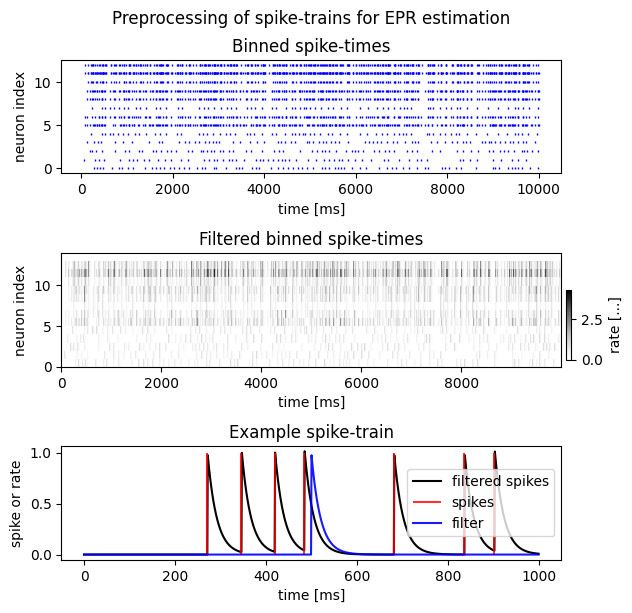

In [52]:
#plot sim for ff network
#load spike-times from rajat's simulation
spikes_l1 = np.array([SM1.t/ms, SM1.i])#np.load('spikes_static1000_l1.npy') #shape (spike-time, neuron_id)
spikes_l2 = np.array([SM2.t/ms, SM2.i])#np.load('spikes_static1000_l2.npy')
spikes_l3 = np.array([SM3.t/ms, SM3.i])#np.load('spikes_static1000_3.npy')

N = 15
Nl = 5
##concatenate inh and exc spikes into one array
# add maximum index of excitatory neurons Ne to indices of inh neurons to distinguish them after concatenation; 
spikes_l1_ix = spikes_l1.copy()
spikes_l2_ix = spikes_l2.copy()
spikes_l3_ix = spikes_l3.copy()

spikes_l2_ix[1] = spikes_l2[1] + Nl  
spikes_l3_ix[1] = spikes_l3[1] + 2*Nl  

spikes = np.hstack((spikes_l1_ix, spikes_l2_ix, spikes_l3_ix)) #concatenate inh and exc spikes into one array, spikes
sp_times, sp_neuron = spikes[0], spikes[1]

#bin spike-times
bin_width = 1 #ms #bin width
print('binning...')
time_bins, binned_spikes = bin_tp_data(spikes, T, bin_width)
#convolve data, to help the epr algorithm detect statistics and trends of data
flt_width = 20 #ms #width of gaussian filter, if used
tau = 20 #ms, time constant of exp filter, if used
print('filtering...')
rate = inst_rate_exp(binned_spikes, tau = tau, height=1, dt=bin_width) #inst_rate(binned_spikes, filter_width = flt_width, dt=bin_width) #

#plot spike time data
print('plotting...')
fig,ax =plt.subplots(3,1,figsize=(5,5))
N, nbins = binned_spikes.shape

#plot binned spikes data
markersize =1
ax[0].set_title('Binned spike-times')
nidx, tp = np.nonzero(binned_spikes) #as arrays are too big and sparse for imshow visualization, extract non-zero element's indices
nidx_l1, tp_l1 = nidx[nidx<5], tp[nidx<5] #and exc
nidx_l2, tp_l2 = nidx[(nidx>=5)&(nidx<10)], tp[(nidx>=5)&(nidx<10)] #divide into indices for inhibitory
nidx_l3, tp_l3 = nidx[nidx>10], tp[nidx>10] #and exc

ax[0].plot(tp*bin_width, nidx,'|', markersize=markersize, color='blue')
# ax[0].plot(tp_l1*bin_width, nidx_l1,'|', markersize=markersize, color='blue')
# ax[0].plot(tp_l2*bin_width, nidx_l2,'|', markersize=markersize, color='red')
# ax[0].plot(tp_l3*bin_width, nidx_l3,'|', markersize=markersize, color='green')
ax[0].set_ylabel('neuron index')

#plot convolved binned spikes
ax[1].set_title('Filtered binned spike-times')
im1 = ax[1].imshow(rate, aspect='auto', origin='lower', cmap='Greys', interpolation='none', extent=[time_bins[0], time_bins[-2], 0, N])
ax[1].set_ylabel('neuron index')

#plot convolved spike-train for example neuron
plot_to_time = 1000 #ms
plot_to = int(plot_to_time/bin_width) #bins
ix = 0
ntp = time_bins[:-1].size
ax[2].set_title('Example spike-train')

ax[2].plot(time_bins[:plot_to], rate[ix, :plot_to], 'black',label='filtered spikes')
# sp_timesi = sp_times[sp_neuron == ix]
# nspikes_in_zoom = int(binned_spikes[ix, :plot_to].sum())  #TODO, zoom into spike times
# ax[2].vlines(sp_timesi[:nspikes_in_zoom],0, np.ones(nspikes_in_zoom),color='red',label='spikes')
example_spike_inds = np.nonzero(binned_spikes[ix, :plot_to])
ax[2].vlines(example_spike_inds, 0, np.ones([len(example_spike_inds)]), color='red', label='spikes', alpha=0.8)
#ax[2].plot(time_bins[:plot_to], binned_spikes[ix, :plot_to], color='r', label='spikes')
ax[2].plot(time_bins[:plot_to], expfilt(np.linspace(-plot_to//2, plot_to//2, plot_to), tau = tau, dt=bin_width), 'blue',alpha=0.9, label='filter')
ax[2].legend(loc='right')
ax[2].set_ylabel('spike or rate')
for axi in ax.flat:
    axi.set_xlabel('time [ms]')
plt.suptitle('Preprocessing of spike-trains for EPR estimation',y=1.1)
#plt.tight_layout()

#add colorbar and determine plot spacing and size
cbar_ax = fig.add_axes([1.01, 0.4, 0.01, 0.14])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
cbar.set_label('rate [...]')
#ax[0]. #TODO: add colorbar
fig.subplots_adjust(0,0,1,1,0.5,0.7)

#TODO: plot blue/red also for other data structures
print('Binned spikes are just as many as spike-times:',binned_spikes.sum()==spikes.shape[1])

In [58]:
#save processed data
print('Im-on-server path:', Im_on_server)
save =True

cd = os.getcwd()
if save:
    
    if Im_on_server:
        path = '/saved_activities/feed forward/' 
    else:
        path = '\\saved_activities\\feed forward\\'
    np.save(cd + path + 'pop-spikes_ff15_seed42_test1', spikes)

Im-on-server path: False


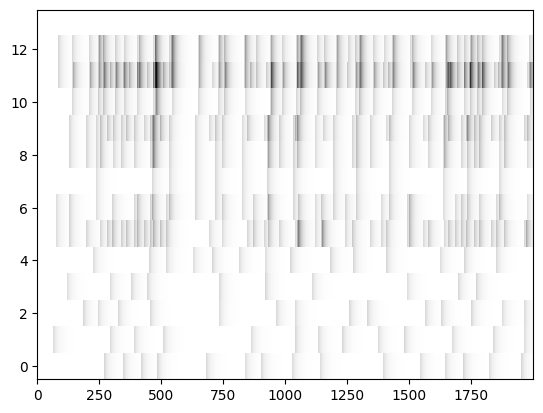

In [54]:
plt.imshow(rate[:,:2000], cmap='Greys',aspect='auto',origin='lower', interpolation='none')